# VecOps
This tutorial shows how VecOps can be used to slim down the programming model typically adopted in HEP for analysis.
We compare the approach of PyROOT and of RDataFrame.

Our dataset contains for every event three collections of floating point numbers of equal size: **E**, **px** and **py**. We can imagine these are properties of muons, or more in general, of *candidates*.
Our goal is to:.
1. Select the candidates in all events for which the energy, *E*, is greater than 100.
2. Calculate the transverse momentum as the square sum of **px** and **py**.
3. Fill a histogram with the transverse momenta.

In [1]:
auto filename = "vecOpsHEP.root";
auto treename = "myDataset";
using doubles = ROOT::VecOps::RVec<double>;
using RDF = ROOT::RDataFrame;

We achieve our goal using the *TTreeReader* interfaces. With the bare usage of *TTree* it would be more cumbersome.

In [2]:
void WithTTreeReader()
{
   TFile f(filename);
   TTreeReader tr(treename, &f);
   TTreeReaderArray<double> px(tr, "px");
   TTreeReaderArray<double> py(tr, "py");
   TTreeReaderArray<double> E(tr, "E");

   TH1F h("pt", "pt", 16, 0, 4);

   while (tr.Next()) {
      for (auto i=0U;i < px.GetSize(); ++i) {
         if (E[i] > 100) h.Fill(sqrt(px[i]*px[i] + py[i]*py[i]));
      }
   }
   h.DrawCopy();
}

We now do this using *RDataFrame*, explicitly expressing our points 1. and 2. as a lambda function and spelling out all templates. Observe how the histogram can be filled with a collection in a way which is transparent to the user.

This is a nice and performant way to proceed, but the programming model can be improved.

In [3]:
void WithRDataFrame()
{
  RDF f(treename, filename);
   auto CalcPt = [](doubles &px, doubles &py, doubles &E) {
      doubles v;
      for (auto i=0U;i < px.size(); ++i) {
         if (E[i] > 100) {
            v.emplace_back(sqrt(px[i]*px[i] + py[i]*py[i]));
         }
      }
      return v;
   };
   f.Define("pt", CalcPt, {"px", "py", "E"})
    .Histo1D<doubles>({"pt", "pt", 16, 0, 4}, "pt")->DrawCopy();
}

We therefore introduce *RVec*. Looping on candidates is now easily dealt with. The density of meaning of the code increases. The opportunities to make mistakes are fewer.

In [4]:
void WithRDataFrameVecOps()
{
   RDF f(treename, filename);
   auto CalcPt = [](doubles &px, doubles &py, doubles &E) {
      auto pt = sqrt(px*px + py*py);
      return pt[E>100];
   };
   f.Define("good_pt", CalcPt, {"px", "py", "E"})
    .Histo1D<doubles>({"pt", "pt", 16, 0, 4}, "good_pt")->DrawCopy();
}

We now exploit the string based interfaces of *RDataFrame*. The template parameters do not need to be expressed but they are still there, implicitly. The code continues to be type safe: it's ROOT's C++ interpreter which does all the heavy lifting.

In [5]:
%%cpp -d
void WithRDataFrameVecOpsJit()
{
   RDF f(treename, filename);
   f.Define("good_pt", "sqrt(px*px + py*py)[E>100]")
    .Histo1D({"pt", "pt", 16, 0, 4}, "good_pt")->DrawCopy();
}

We plot four times the same quantity, the key is to look into the implementation
 of the functions above

In [6]:
TCanvas c;
c.Divide(2,2);
c.cd(1);
WithTTreeReader();
c.cd(2);
WithRDataFrame();
c.cd(3);
WithRDataFrameVecOps();
c.cd(4);
WithRDataFrameVecOpsJit();

Draw all canvases 

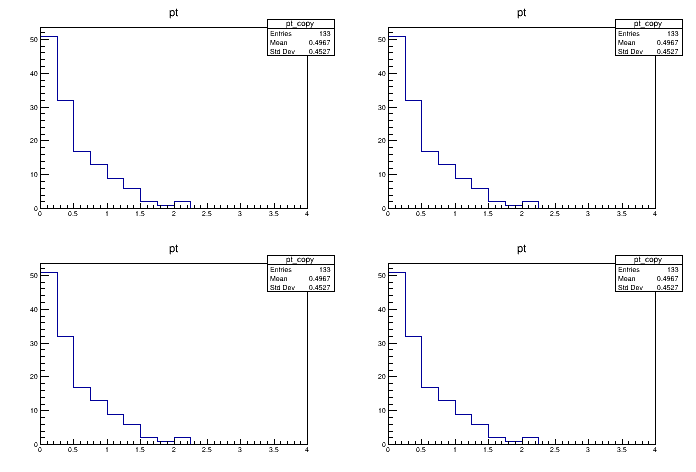

In [7]:
c.Draw()